# Importing Modules

In [1]:
import yaml
import sys
import hickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join as path_join
from operator import itemgetter
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings("ignore")

# Importing Dataset

In [3]:
config_file = path_join("config", "config.yml")

In [4]:
with open(config_file) as f:
    config = yaml.safe_load(f)

In [5]:
train_orig = pd.read_csv(config["dataset"]["train"])
test_orig = pd.read_csv(config["dataset"]["test"])

In [6]:
train = train_orig.copy()
test = test_orig.copy()

# EDA

In [7]:
print(train.shape, test.shape)

(614, 13) (367, 12)


In [8]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Co

(None, None)

### Checking for null values

In [9]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Missing values are idenfied in Gender, Married, Dependents, Self_Employed, Loan Amount, Loan_Amount_Term, Credit_History

In [10]:
test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

Missing values are indetified in Gender, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term, Credit_History

These null values will give impact on the data training and will give bias to the model while imputing. Instead we can drop the
na to avoid noise and bias in train and test data

### Data Cleaning

In [11]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [12]:
train.shape, test.shape

((480, 13), (289, 12))

### Data Analyzing

In [13]:
train["Loan_Status"].value_counts()

Y    332
N    148
Name: Loan_Status, dtype: int64

#### Indentifying the Approved Loan status of each Attibutes

In [14]:
train[train["Loan_Status"] == "Y"]["Gender"].value_counts()

Male      278
Female     54
Name: Gender, dtype: int64

<AxesSubplot:>

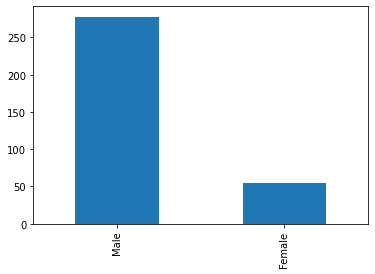

In [15]:
train[train["Loan_Status"] == "Y"]["Gender"].value_counts().plot.bar()

Loans are get approved for Male is high in numbers

In [16]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male")]["Married"].value_counts()

Yes    210
No      68
Name: Married, dtype: int64

In [17]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female")]["Married"].value_counts()

No     37
Yes    17
Name: Married, dtype: int64

Married males are higher in number and unmarried Females are higher in number

In [18]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "Yes")]["Dependents"].value_counts()

0     86
2     59
1     40
3+    25
Name: Dependents, dtype: int64

In [19]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "Yes")]["Dependents"].value_counts()

0    10
1     5
2     2
Name: Dependents, dtype: int64

As we looks loans got approved for without dependents is higher compare to with dependets for both married males and Femals

In [20]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "No")]["Dependents"].value_counts()

0     59
2      4
1      3
3+     2
Name: Dependents, dtype: int64

In [21]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "No")]["Dependents"].value_counts()

0     32
1      4
3+     1
Name: Dependents, dtype: int64

Even for unmarried without dependent is higher than with dependent for both male and Female

In [22]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "Yes") &
      (train["Dependents"] == "0")]["Education"].value_counts()

Graduate        76
Not Graduate    10
Name: Education, dtype: int64

In [23]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "Yes") &
      (train["Dependents"] == "0")]["Education"].value_counts()

Graduate        8
Not Graduate    2
Name: Education, dtype: int64

In [24]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "No") &
      (train["Dependents"] == "0")]["Education"].value_counts()

Graduate        46
Not Graduate    13
Name: Education, dtype: int64

In [25]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "No") &
      (train["Dependents"] == "0")]["Education"].value_counts()

Graduate        25
Not Graduate     7
Name: Education, dtype: int64

Loan got approved for both Married and Unmarried Males and Female graduate is higher than Non Graduate for non dependent

In [26]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "Yes") &
      (train["Dependents"] > "0")]["Education"].value_counts()

Graduate        97
Not Graduate    27
Name: Education, dtype: int64

Approval for loans are higher for Graduated Married males with the Dependent

In [27]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "Yes") &
      (train["Dependents"] > "0")]["Education"].value_counts()

Graduate    7
Name: Education, dtype: int64

Only for the Graduate Married womens are getting Loans with minimal number

In [28]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "Yes") &
      (train["Dependents"] == "0") & (train["Education"] == "Graduate")]["Self_Employed"].value_counts()

No     67
Yes     9
Name: Self_Employed, dtype: int64

In [29]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Male") & (train["Married"] == "No") &
      (train["Dependents"] == "0") & (train["Education"] == "Graduate")]["Self_Employed"].value_counts()

No     40
Yes     6
Name: Self_Employed, dtype: int64

Compare to male both married and unmarried Graduated self employed, salaried person are higher with Dependents

In [30]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "Yes") &
      (train["Dependents"] == "0") & (train["Education"] == "Graduate")]["Self_Employed"].value_counts()

No    8
Name: Self_Employed, dtype: int64

Loans are got approved only for Married Female salaried employee without dependents

In [31]:
train[(train["Loan_Status"] == "Y") & (train["Gender"] == "Female") & (train["Married"] == "No") &
      (train["Dependents"] == "0") & (train["Education"] == "Graduate")]["Self_Employed"].value_counts()

No     24
Yes     1
Name: Self_Employed, dtype: int64

Only one single female educated self employed got the loan approval without dependent

In [32]:
train[(train["Loan_Status"] == "Y")]["Property_Area"].value_counts()

Semiurban    149
Urban         98
Rural         85
Name: Property_Area, dtype: int64

# Preparing the Train and Test Dataset

In [33]:
train=train.drop('Loan_ID',axis=1)
test=test.drop('Loan_ID',axis=1)

In [34]:
X = train.drop('Loan_Status',1) 
y = train.Loan_Status

### Now we will make dummy variables for the categorical variables.

In [35]:
X = pd.get_dummies(X)

# Model Selection:

### Selecting the best suitable model for Loan prediction

In [36]:
models = [
          KNeighborsClassifier(),
          LogisticRegression(),
          RandomForestClassifier(),
          DecisionTreeClassifier(),
          SVC(),
          GradientBoostingClassifier(),
          XGBClassifier()
]

In [37]:
CV = 5
cv_df = pd.DataFrame(index = range(CV * len(models)))

In [38]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X,y, scoring = 'accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])

In [39]:
cv_df

,model_name,fold_idx,accuracy
0,KNeighborsClassifier,0,0.677083
1,KNeighborsClassifier,1,0.677083
2,KNeighborsClassifier,2,0.666667
3,KNeighborsClassifier,3,0.583333
4,KNeighborsClassifier,4,0.645833
5,LogisticRegression,0,0.802083
6,LogisticRegression,1,0.781250
7,LogisticRegression,2,0.781250
8,LogisticRegression,3,0.854167
9,LogisticRegression,4,0.760417


As we found that the Logistic Regression play the leading role compare other models. Hence we can choose GradientBoostingClassifier as Model Selection

# Model Building

#### Fetching the seed value for the highest model prediction

In [40]:
train_results = []
for i in range(1,201):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = i)
    classifier = GradientBoostingClassifier(n_estimators=200)
    clf = classifier.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    if test_score < train_score:
        train_results.append({"train_score":train_score,"test_score":test_score,"seed":i})
        print('Train Score :{} Test Score :{} Random seed:{}'.format(train_score,test_score,i))

Train Score :0.9965277777777778 Test Score :0.7760416666666666 Random seed:1
Train Score :1.0 Test Score :0.7552083333333334 Random seed:2
Train Score :0.9930555555555556 Test Score :0.75 Random seed:3
Train Score :0.9965277777777778 Test Score :0.8020833333333334 Random seed:4
Train Score :1.0 Test Score :0.75 Random seed:5
Train Score :1.0 Test Score :0.7604166666666666 Random seed:6
Train Score :0.9965277777777778 Test Score :0.734375 Random seed:7
Train Score :0.9930555555555556 Test Score :0.7552083333333334 Random seed:8
Train Score :0.9895833333333334 Test Score :0.7291666666666666 Random seed:9
Train Score :0.9965277777777778 Test Score :0.8125 Random seed:10
Train Score :0.9930555555555556 Test Score :0.7552083333333334 Random seed:11
Train Score :1.0 Test Score :0.75 Random seed:12
Train Score :0.9965277777777778 Test Score :0.734375 Random seed:13
Train Score :1.0 Test Score :0.734375 Random seed:14
Train Score :0.9965277777777778 Test Score :0.7708333333333334 Random seed:1

Train Score :0.9965277777777778 Test Score :0.796875 Random seed:123
Train Score :1.0 Test Score :0.7864583333333334 Random seed:124
Train Score :1.0 Test Score :0.734375 Random seed:125
Train Score :1.0 Test Score :0.78125 Random seed:126
Train Score :0.9895833333333334 Test Score :0.7760416666666666 Random seed:127
Train Score :0.9965277777777778 Test Score :0.7760416666666666 Random seed:128
Train Score :0.9861111111111112 Test Score :0.796875 Random seed:129
Train Score :0.9965277777777778 Test Score :0.7916666666666666 Random seed:130
Train Score :0.9965277777777778 Test Score :0.7447916666666666 Random seed:131
Train Score :0.9965277777777778 Test Score :0.7395833333333334 Random seed:132
Train Score :0.9965277777777778 Test Score :0.7604166666666666 Random seed:133
Train Score :0.9895833333333334 Test Score :0.8125 Random seed:134
Train Score :0.9965277777777778 Test Score :0.765625 Random seed:135
Train Score :0.9965277777777778 Test Score :0.75 Random seed:136
Train Score :0.9

In [41]:
new_train_res = sorted(train_results, key=itemgetter('test_score','train_score'),reverse=True)

In [42]:
seed = new_train_res[0]['seed']

In [43]:
seed

189

#### Train Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=seed)

#### Training the model

In [70]:
model = GradientBoostingClassifier(n_estimators=200,random_state=seed)

In [71]:
gr = model.fit(X_train,y_train)

In [72]:
y_pred_train = gr.predict(X_train)

In [73]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           N       1.00      1.00      1.00        94
           Y       1.00      1.00      1.00       194

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [74]:
print("Train Score:", model.score(X_train, y_train))

Train Score: 1.0


#### Predicting the test data

In [75]:
hickle.dump(model, "loan_prediction.hkl")

In [76]:
model = hickle.load("loan_prediction.hkl")
y_pred = model.predict(X_test)

In [77]:
print("Test Score:", model.score(X_test, y_test))

Test Score: 0.8229166666666666


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.81      0.48      0.60        54
           Y       0.82      0.96      0.89       138

    accuracy                           0.82       192
   macro avg       0.82      0.72      0.75       192
weighted avg       0.82      0.82      0.81       192



#### Confusion Matrix(Train)

In [79]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)

[[ 94   0]
 [  0 194]]


<AxesSubplot:>

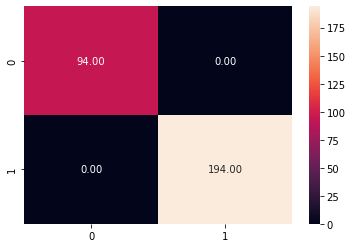

In [80]:
sns.heatmap(cm, annot = True, fmt = '0.2f')

In [81]:
df_confusion_train = pd.crosstab(y_train, y_pred_train, rownames= [ 'Actual'], colnames = [ 'Predicted'], margins = True)
df_confusion_train

Predicted,N,Y,All
Actual,,,
N,94,0,94
Y,0,194,194
All,94,194,288


#### Confusion Matrix(Test)

In [82]:
cm_test = confusion_matrix(y_test, y_pred)
print(cm_test)

[[ 26  28]
 [  6 132]]


<AxesSubplot:>

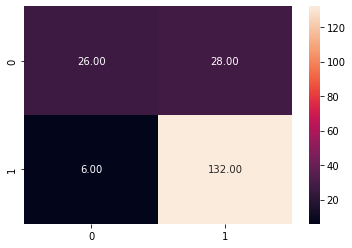

In [83]:
sns.heatmap(cm_test, annot = True, fmt = '0.2f')

In [84]:
df_confusion_test = pd.crosstab(y_test, y_pred, rownames= [ 'Actual'], colnames = [ 'Predicted'], margins = True)
df_confusion_test

Predicted,N,Y,All
Actual,,,
N,26,28,54
Y,6,132,138
All,32,160,192


# Validation Data Set

In [85]:
gf_model = hickle.load("loan_prediction.hkl")

In [86]:
test = pd.get_dummies(test)

In [87]:
test.shape, test_orig.shape

((289, 20), (289, 12))

In [88]:
pred = gf_model.predict(test)

In [89]:
final_submission = pd.DataFrame()

In [90]:
test_orig.dropna(inplace=True)

In [91]:
final_submission['Loan_ID']=test_orig['Loan_ID']
final_submission['Loan_Status']=pred

In [92]:
final_submission["Loan_Status"].value_counts()

Y    223
N     66
Name: Loan_Status, dtype: int64

In [93]:
final_submission.to_csv("submission.csv")

In [104]:
(int(final_submission[final_submission["Loan_Status"] == "Y"]["Loan_Status"].value_counts()[0]) / int(final_submission.shape[0]))*100

77.16262975778547

In [101]:
final_submission.shape[0]

289